# Filter down the folded paired states to an orderable subset

### Imports

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/crispy_shifty/projects/OPS/round_1/design
running on node: sofia


### Fix the paths
Necessary because we copied these designs from perlmutter

### Filter the predicted states

In [2]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "13_filter_and_order"
design_list_file = "/home/broerman/crispy_shifty/projects/OPS/round_1/design/12_fold_all_states/folded_paired_states.list"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)
options = " ".join(
    [
        "out:level 200",
        "corrections:beta_nov16 true",
        "indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.msd.filter_paired_state_OPS",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="3584M",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-7814 /home/broerman/crispy_shifty/projects/OPS/round_1/design/12_filter_and_order/run.sh


### Collect scorefiles of the filtered states and concatenate

In [2]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "13_filter_and_order"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [3]:
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

100%|██████████| 7814/7814 [00:44<00:00, 177.02it/s]


### Dump scores_df as a CSV and then reload, for performance reasons

In [4]:
simulation_name = "13_filter_and_order"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [5]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration

In [6]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

### Remove score terms we don't care about

In [7]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

1084
['A_final_seq', 'A_sap', 'A_score_per_res', 'A_total_score', 'A_wnm_all', 'A_wnm_helix', 'B_final_seq', 'B_sap', 'B_score_per_res', 'B_total_score', 'B_wnm_all', 'B_wnm_helix', 'C_final_seq', 'C_sap', 'C_score_per_res', 'C_total_score', 'C_wnm_all', 'C_wnm_helix', 'X_cms', 'X_ddg', 'X_sap', 'X_score_per_res', 'X_total_score', 'Y_cms', 'Y_ddg', 'Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_sap', 'Y_score_per_res', 'Y_seed', 'Y_tol', 'Y_total_score', 'Y_type', 'bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fixed_resis', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'interface', 'loop_dist', 'loop_sc', 'looped

In [8]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot Y Rosetta metrics

16it [00:00, 18.72it/s]


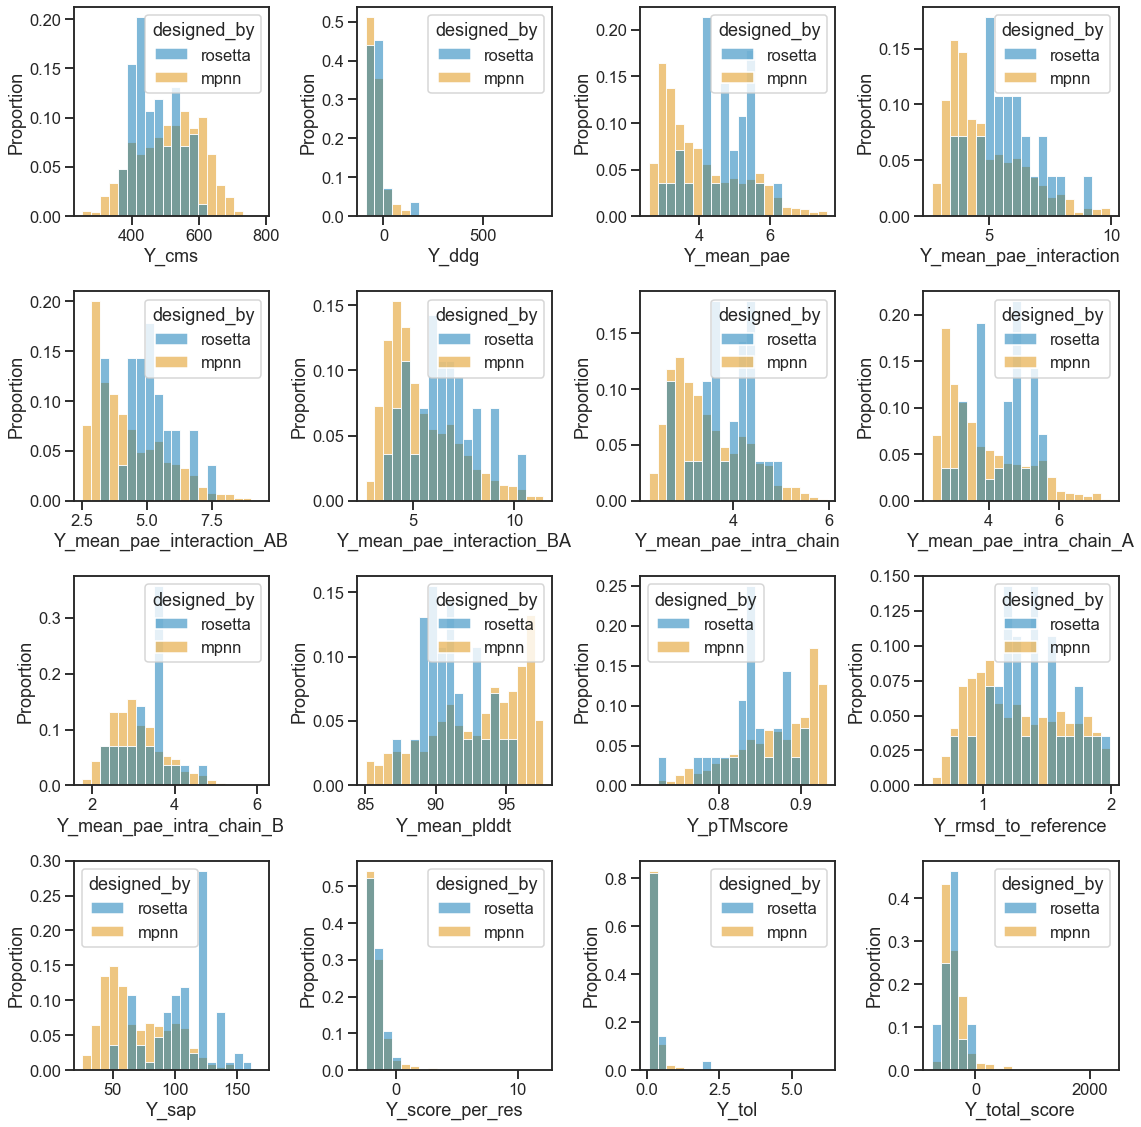

In [9]:
avoid = ["Y_model", "Y_recycles", "Y_seed", "Y_type"]
cols = [col for col in scores_df.columns if "Y_" in col and col not in avoid]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "Y_all_scores.png"))

5it [00:00, 19.94it/s]


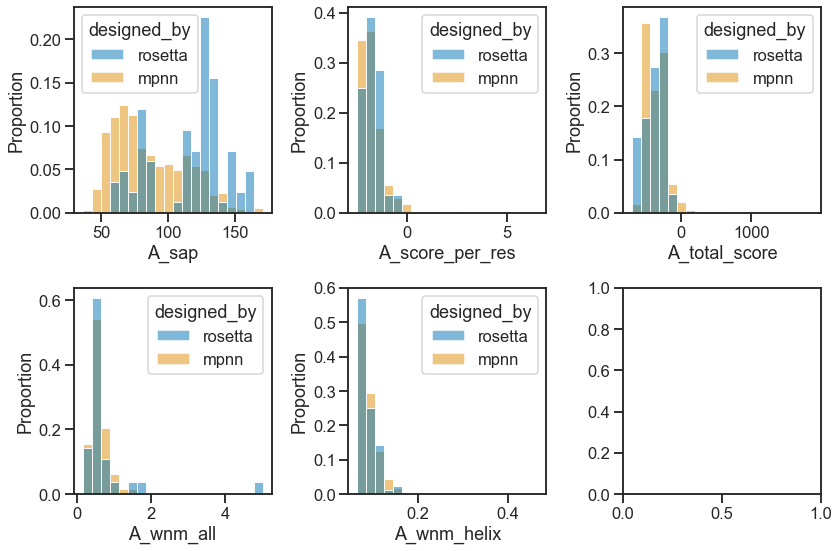

In [10]:
cols = [col for col in scores_df.columns if "A_" in col and "final_seq" not in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "A_all_scores.png"))

5it [00:00, 20.10it/s]


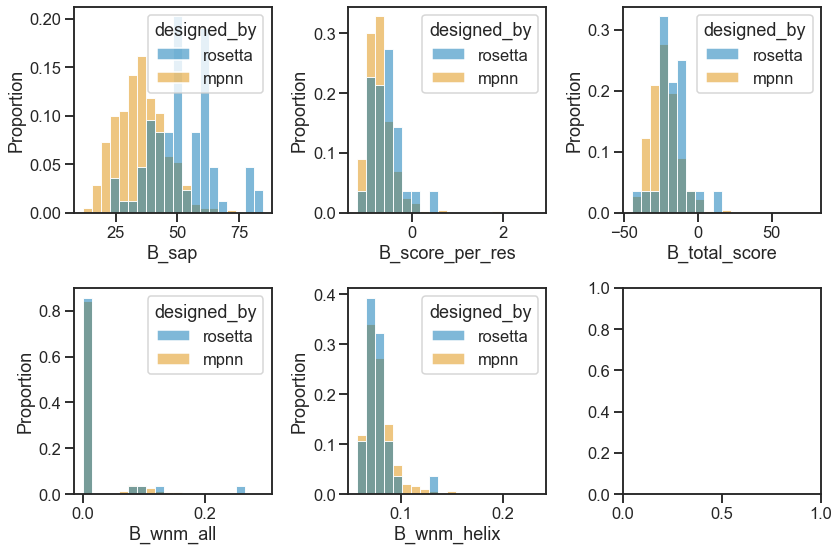

In [11]:
cols = [col for col in scores_df.columns if "B_" in col and "final_seq" not in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "B_all_scores.png"))

5it [00:00, 20.05it/s]


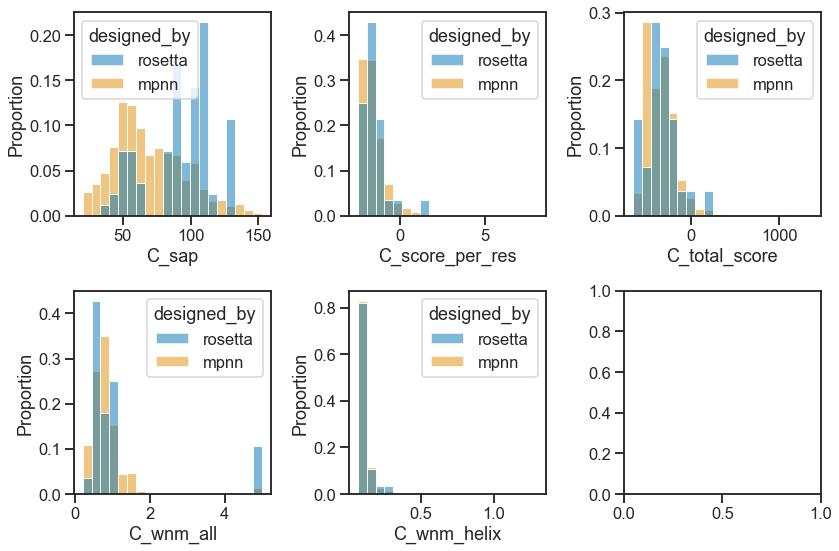

In [12]:
cols = [col for col in scores_df.columns if "C_" in col and "final_seq" not in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "C_all_scores.png"))

8it [00:00, 19.34it/s]


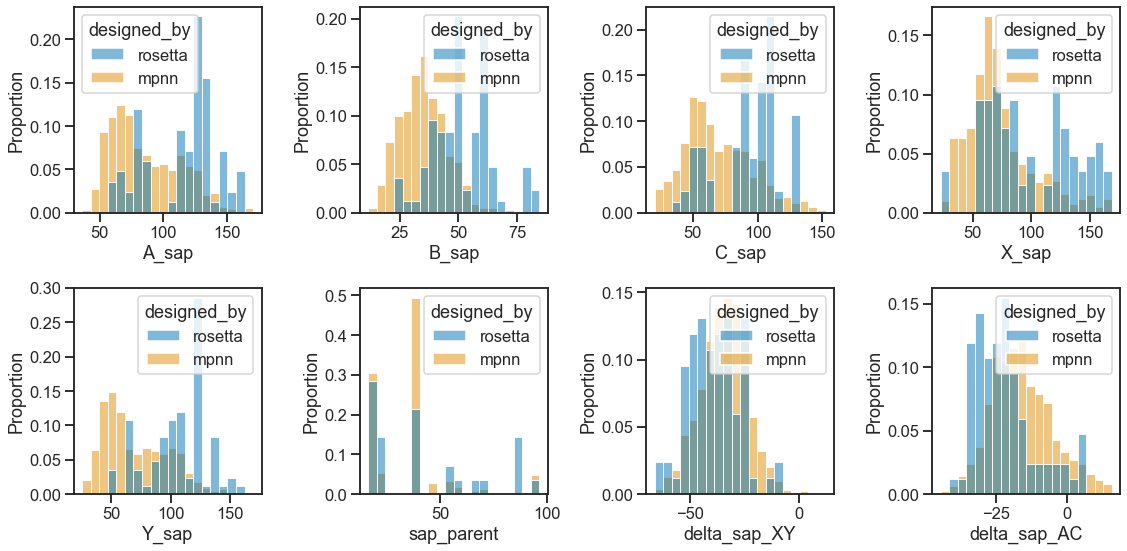

In [13]:
sample_df["delta_sap_XY"] = sample_df["Y_sap"] - (
    sample_df["C_sap"] + sample_df["B_sap"]
)
sample_df["delta_sap_AC"] = sample_df["C_sap"] - sample_df["A_sap"]


cols = [col for col in scores_df.columns if "sap" in col] + [
    "delta_sap_XY",
    "delta_sap_AC",
]


the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "sap_all_scores.png"))

<Figure size 2304x2304 with 0 Axes>

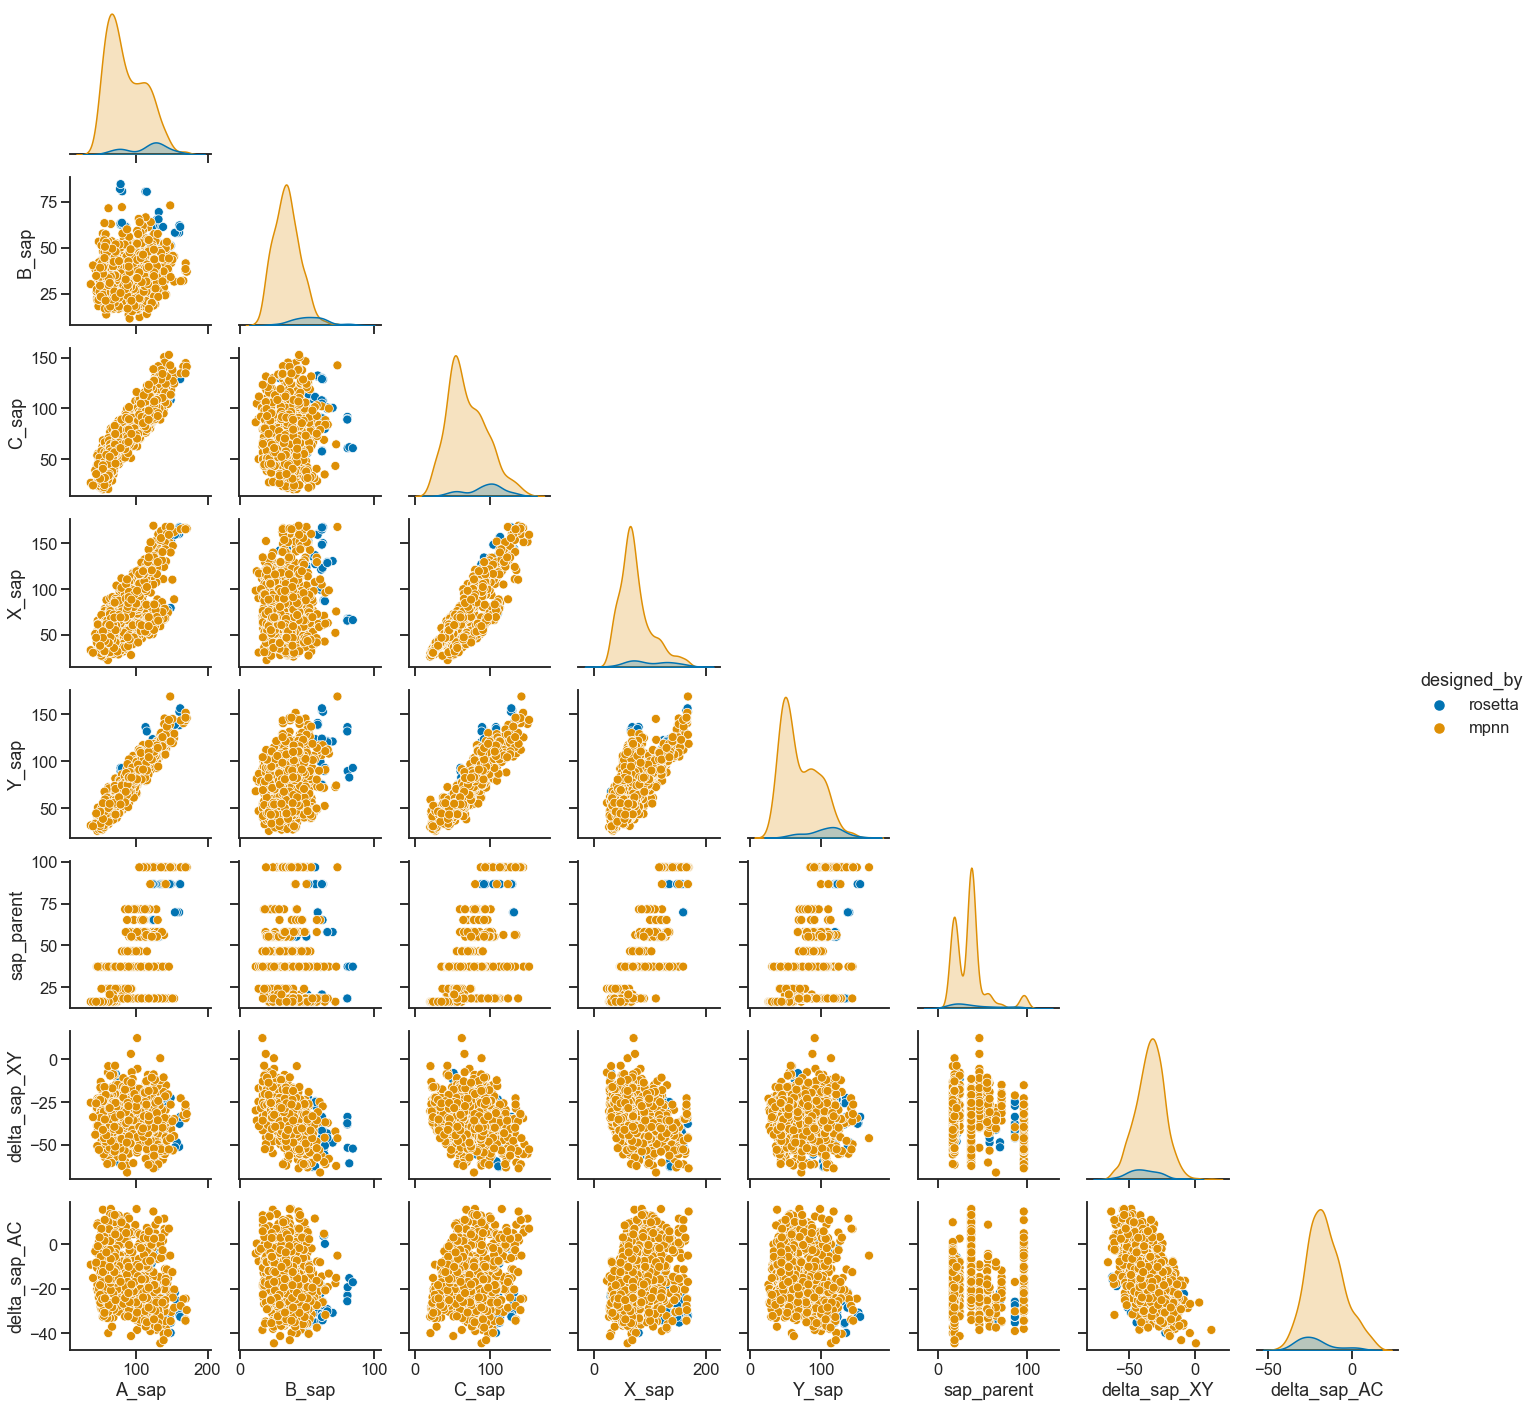

In [14]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "sap_all_scores_paired.png"))

14it [00:00, 15.44it/s]


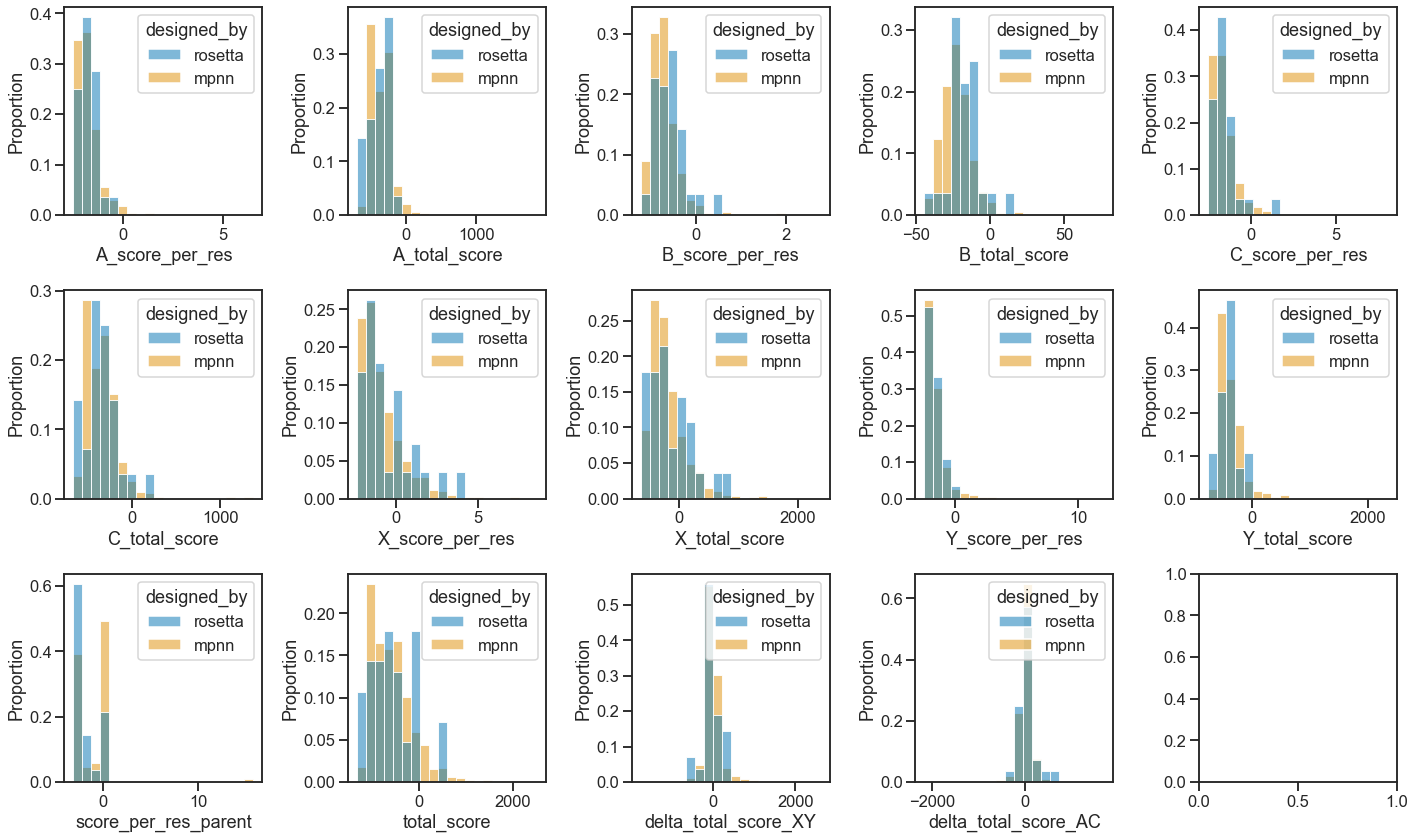

In [15]:
sample_df["delta_total_score_XY"] = sample_df["Y_total_score"] - (
    sample_df["C_total_score"] + sample_df["B_total_score"]
)
sample_df["delta_total_score_AC"] = (
    sample_df["C_total_score"] - sample_df["A_total_score"]
)
avoid = ["Y_pTMscore", "pTMscore", "score", "score_per_res", "score_per_res_x"]
cols = [col for col in scores_df.columns if "score" in col and col not in avoid] + [
    "delta_total_score_XY",
    "delta_total_score_AC",
]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "rosetta_all_scores.png"))

11it [00:00, 19.38it/s]


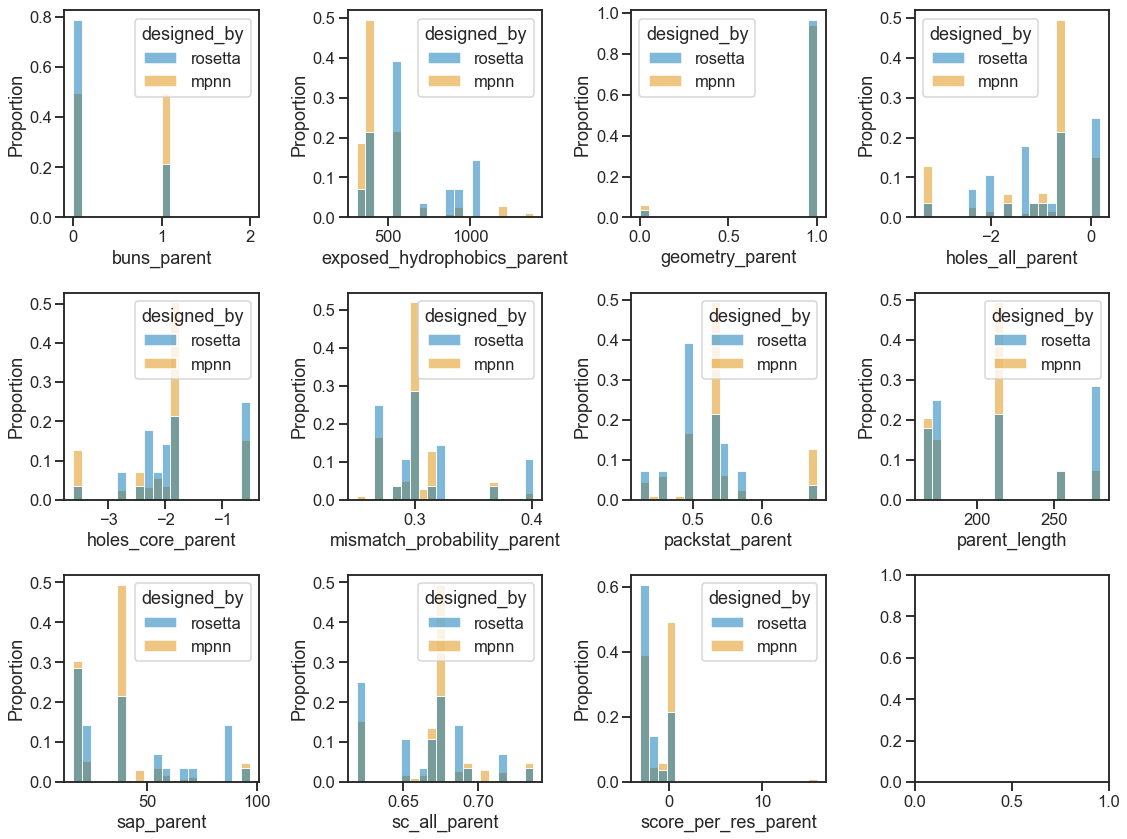

In [16]:
cols = [col for col in scores_df.columns if "parent_" in col or "_parent" in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "parent_all_scores.png"))

### Do some initial filtering on Rosetta metrics, especially SAP

#### TODO

Use absolute cutoffs, or cutoffs relative to the parent, buyt don't go by state and a target representation

### Final filtering on AF2 metrics

Filtering strategy: assign ranges to these distributions to remove outliers. Then for each state, shrink the fraction of that range you take from each distribution until you hit a target number, say 10. Those 10 will then be the overall best across all the metrics.

Make sure to get designs from each pivot helix per parent (this is ensured by doing this for every state).

8it [00:00, 18.47it/s]


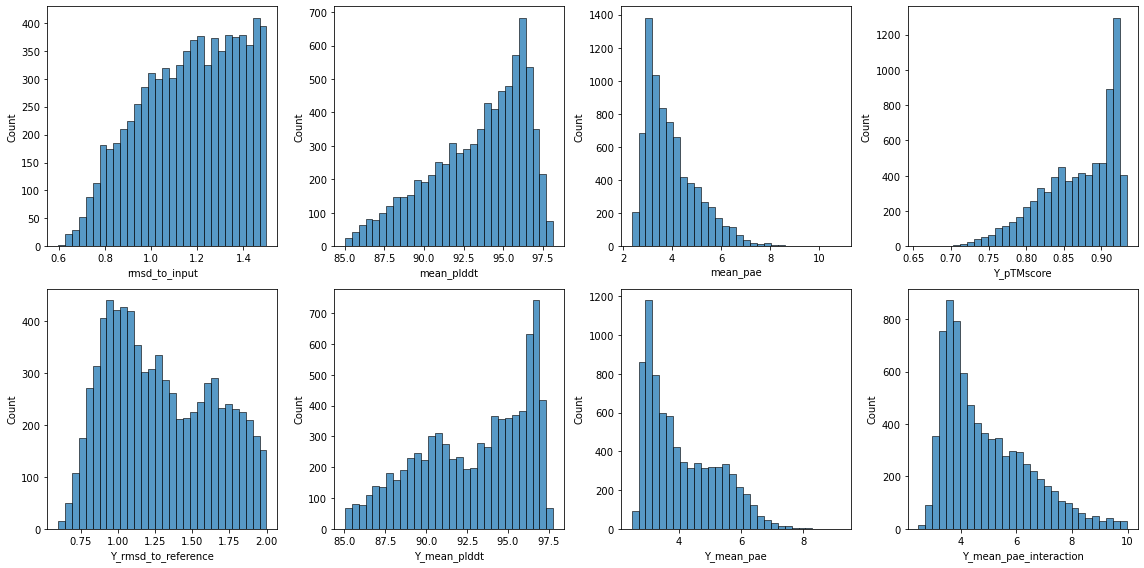

In [123]:
# plot all filtering metrics
filtering_cols = [
    "rmsd_to_input",
    "mean_plddt",
    "mean_pae",
    "Y_pTMscore",
    "Y_rmsd_to_reference",
    "Y_mean_plddt",
    "Y_mean_pae",
    "Y_mean_pae_interaction",
]
the_fig = histplot_df(
    df=scores_df,
    cols=filtering_cols,
    bins=30,
)

In [ ]:
scores_df = scores_df.query("Y_pTMscore > 0.75")

filtering_cols = [
    "rmsd_to_input",
    "mean_plddt",
    "mean_pae",
    "Y_pTMscore",
    "Y_rmsd_to_reference",
    "Y_mean_plddt",
    "Y_mean_pae",
    "Y_mean_pae_interaction",
]
minimize_cols = [True, False, True, False, False, True, True, True]

target_representation = 10

all_states = set(scores_df.state.values)
state_dfs = []
for state in all_states:
    state_df = scores_df[scores_df.state == state]

    if len(state_df) > target_representation:
        # find the 10 designs which have all filtering metrics above the quantile cutoff
        filtering_df = pd.DataFrame(columns=filtering_cols)
        for col, minimize in zip(filtering_cols, minimize_cols):
            if minimize:
                filtering_df[col] = -state_df[col]
            else:
                filtering_df[col] = state_df[col]

        df_len = len(filtering_df)
        q = 0.5
        min_q = 0
        max_q = 1
        n_iter = 0
        while df_len != target_representation:
            filtered_df = filtering_df[filtering_df > filtering_df.quantile(q)].dropna()
            df_len = len(filtered_df)
            if n_iter > 100:
                # if it's impossible to distinguish among designs, just take the best 10 by X plddt
                filtered_df = filtering_df[filtering_df > filtering_df.quantile(min_q)].dropna().sort_values(by="mean_plddt", ascending=False).head(target_representation)
                print("iteration limit reached")
                break
            if df_len < target_representation:
                max_q = q
                q = (max_q + min_q) / 2
            elif df_len > target_representation:
                min_q = q
                q = (max_q + min_q) / 2
            n_iter += 1
        
        state_df = state_df.loc[filtered_df.index, :]

    state_dfs.append(state_df)

filtered_df = pd.concat(state_dfs)
filtered_df

9it [00:00, 34.10it/s]


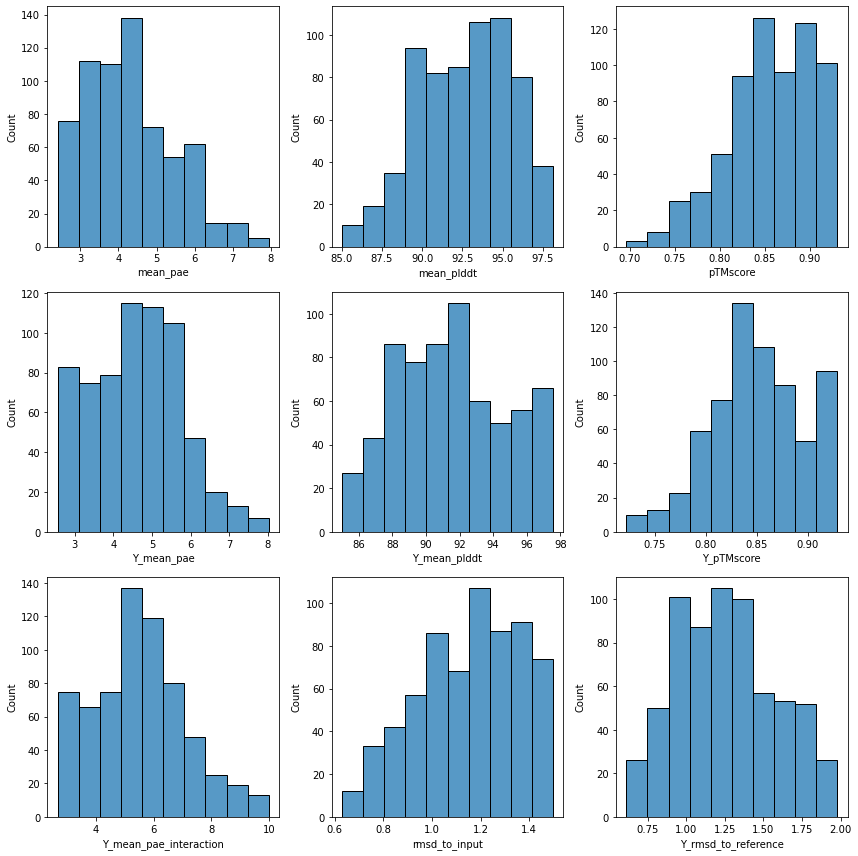

In [122]:
# plot all filtering metrics
the_fig = histplot_df(
    df=filtered_df,
    cols=filtering_cols,
    bins=10,
)

### Filter the whole df

In [18]:
scores_df["delta_sap_XY"] = scores_df["Y_sap"] - (
    scores_df["C_sap"] + scores_df["B_sap"]
)
scores_df["delta_sap_AC"] = scores_df["C_sap"] - scores_df["A_sap"]

scores_df["delta_total_score_XY"] = scores_df["Y_total_score"] - (
    scores_df["C_total_score"] + scores_df["B_total_score"]
)
scores_df["delta_total_score_AC"] = (
    scores_df["C_total_score"] - scores_df["A_total_score"]
)
query = " ".join(
    [
        "delta_total_score_XY < 0",
        "and delta_total_score_AC < 0",
        "and delta_sap_XY < 0",
        "and delta_sap_AC < 0",
        "and B_sap < 50",
        "and C_sap < 50",
        "and Y_sap < 80",
    ]
)

filtered = scores_df.query(query)
len(filtered)

679

In [19]:
print(list(sorted(set([v for v in filtered.state.values if len(v) == 17]))))

['DHR20_p_4_s_3_d_3', 'DHR26_p_4_s_3_d_5', 'DHR27_p_4_s_3_d_3', 'DHR54_p_5_s_3_d_6', 'DHR80_p_5_s_3_d_4', 'DHR81_p_5_s_3_d_4', 'DHR81_p_5_s_3_d_6', 'DHR82_p_5_s_3_d_4']


### Get a set of 24 by getting at least one of each state and maxing some metrics

In [20]:
to_order = []

for state in sorted(list(set(filtered.state.values))):
    if len(state) != 17:
        continue
    else:
        subset_df = filtered.query(f"state == @state")
        # if len is less than or equal to 3 take all,
        if len(subset_df) <= 3:
            to_order.extend(list(subset_df.index))
        # else, take min sap_C, min delta_sap_XY, and min delta_total_score_XY
        else:
            subset_df.sort_values(
                "C_sap", axis=0, ascending=True, ignore_index=False, inplace=True
            )
            to_order.append(list(subset_df.index)[0])
            subset_df.sort_values(
                "delta_sap_XY", axis=0, ascending=True, ignore_index=False, inplace=True
            )
            # check to see if it was already added
            for i in range(len(subset_df)):
                if list(subset_df.index)[i] not in to_order:
                    to_order.append(list(subset_df.index)[i])
                    break
                else:
                    continue
            subset_df.sort_values(
                "delta_total_score_XY",
                axis=0,
                ascending=True,
                ignore_index=False,
                inplace=True,
            )
            # check to see if it was already added
            for i in range(len(subset_df)):
                if list(subset_df.index)[i] not in to_order:
                    to_order.append(list(subset_df.index)[i])
                    break
                else:
                    continue
# add 3 random ones to get to 24
random_dhr_df = filtered.query("scaffold_type == 'tj_DHRs_final'").sample(
    3, random_state=0
)
to_order.extend(list(random_dhr_df.index))

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [21]:
print(len(to_order))
print(len(set(to_order)))

24
24


In [22]:
to_order_df = scores_df.loc[to_order]

In [23]:
# to_order_df.delta_total_score_XY.values
to_order_df.columns

Index(['A_final_seq', 'A_sap', 'A_score_per_res', 'A_total_score', 'A_wnm_all',
       'A_wnm_helix', 'B_final_seq', 'B_sap', 'B_score_per_res',
       'B_total_score',
       ...
       'total_length', 'total_score', 'trimmed_length', 'type', 'wnm_all_x',
       'yhh_planarity', 'delta_sap_XY', 'delta_sap_AC', 'delta_total_score_XY',
       'delta_total_score_AC'],
      dtype='object', length=147)

In [24]:
def seq2chargeA(row: pd.Series, chain: str) -> float:
    from Bio.SeqUtils.ProtParam import ProteinAnalysis

    seq = row[f"{chain}_final_seq"]
    analysis = ProteinAnalysis(seq)
    return analysis.charge_at_pH(7)


to_order_df["A_charge"] = to_order_df.progress_apply(seq2chargeA, chain="A", axis=1)
to_order_df["B_charge"] = to_order_df.progress_apply(seq2chargeA, chain="B", axis=1)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

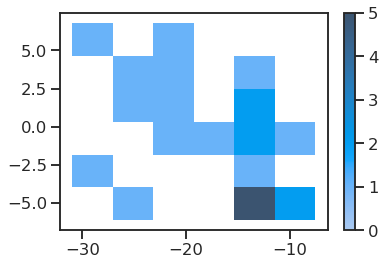

In [25]:
the_fig = sns.histplot(
    x=to_order_df.A_charge.values, y=to_order_df.B_charge.values, cbar=True
)

### Save a list of outputs

In [26]:
simulation_name = "13_filter_and_order"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

with open(os.path.join(output_path, "filtered_orderable.list"), "w") as f:
    for path in tqdm(to_order):
        print(path, file=f)

  0%|          | 0/24 [00:00<?, ?it/s]

### Make an order with `domesticator`
TODO do this better in production

In [27]:
def cmd_no_stderr(command, wait=True):
    """@nrbennet @bcov @pleung"""

    import subprocess

    the_command = subprocess.Popen(
        command,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True,
    )
    if not wait:
        return
    the_stuff = the_command.communicate()
    return str(the_stuff[0])


def capture_1shot_domesticator(stdout: str) -> str:
    """split input into lines.
    loop once through discarding lines up to ones including >.
    return joined output"""
    sequence = []
    append = False
    for line in stdout.splitlines():
        if append:
            sequence.append(line)
        else:
            pass
        if ">unknown_seq1" in line:
            append = True
        else:
            pass
    to_return = "".join(sequence)
    return to_return

### Reindex `to_order_df` and make sure it is set to the same order as the ordered sequences
previously had an issue where the order got mixed up due to the non-deterministic `set()` method in python

In [28]:
order = []
with open(os.path.join(output_path, "filtered_orderable.list"), "r") as f:
    for line in f:
        order.append(line.rstrip())
to_order_df = to_order_df.reindex(order)
ids = [f"cs_{i}" for i in range(200, 224)]
to_order_df["id"] = ids
to_order_df.head()

,A_final_seq,A_sap,A_score_per_res,A_total_score,A_wnm_all,A_wnm_helix,B_final_seq,B_sap,B_score_per_res,B_total_score,...,type,wnm_all_x,yhh_planarity,delta_sap_XY,delta_sap_AC,delta_total_score_XY,delta_total_score_AC,A_charge,B_charge,id
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_1e3b2aab29414c85acd4b5738d4ba4b1.pdb.bz2,EMKEEIRRLAEELEKKTKDEEVKELARKAAELAEKSDNEEVLEVVK...,38.379292,-1.865501,-287.287109,0.357096,0.084025,EERKKKLAREVVREARRLIERLAEEE,24.307537,-0.804908,-20.927603,...,monomer_ptm,0.811603,0.0,-5.638378,-20.378883,-349.884287,-23.304626,-14.054658,0.858681,cs_200
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_81621ef5e5204b6ca56877a661b9bf63.pdb.bz2,SMKEEIRKLAEELEKKSTDEEVKRLAREAAELAEKSKDERVLEVVK...,43.825504,-0.050750,-7.815495,1.119960,0.074414,MEEREELARKVIELAEEIIKELAEKE,32.887589,-0.802612,-20.867918,...,monomer_ptm,0.659009,0.0,-5.501322,-18.554800,-65.121935,-118.101390,-8.376190,-5.469320,cs_201
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_e23a3da1b3684c928342ae2159d29b6e.pdb.bz2,MMREEIERLARELRERTEDEEVRRLAEEAAELARESEDEEVLEIVK...,50.739410,-2.004133,-308.636505,0.615830,0.075987,EEEKEELRKEIIERAKKLIERLAKEA,27.463758,-1.210908,-31.483608,...,monomer_ptm,0.665467,0.0,-5.037582,-22.364496,-362.372288,-31.956879,-18.386227,-1.145714,cs_202
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0003/09_filter_and_order_8f66e3c2aa414e35add1c6572b7f3609.pdb.bz2,DKEERLRQQVEKAEKKLEKLAKQSTDEEVRQIAREVAKQLRRLAEL...,61.017479,-1.878329,-392.570709,0.457711,0.088850,MEEKVEKIKELVKEMVELAIKWAEEKIKELEES,42.494061,-1.051593,-34.702560,...,monomer_ptm,0.710969,0.0,-6.627865,-22.018204,-451.793076,-13.326172,-13.125919,-4.475723,cs_203
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_e843aaa59cf14fadbbf752bb07a548b0.pdb.bz2,TRQKEQLDEVLEEIQRLAEEARKRETDEERAKKIQEEAEKAKELLR...,57.303333,-1.938689,-418.756714,0.460491,0.088282,SEEKEERVLERLLRVSRLIAEAVKRAMEMLVEAS,48.960304,-0.762050,-25.909695,...,monomer_ptm,0.625269,0.0,-12.231697,-30.262318,-482.006809,-3.022339,-22.440404,-1.519418,cs_204


### Reverse translate

In [ ]:
prefix = "atactacggtctcaagga"  # for scarless cloning
suffix = "GGttcccgagaccgtaatgc"  # for scarless cloning
long_prefix = "TTTAGCGCGCCGCCTGACGGATGATGCGCGAAGAAATTGAACGCCTGGCGCGCGAATTCGTGAACGTACCGAAGATGAAGAGGTGCGCCGACatactacggtctcaagga"
long_suffix = "GGttcccgagaccgtaatgcAAATGAAAGAGGAAATTCGCCGCCTGGCGGAAGAACTGGAAAAGAAAACGAAAGATGAAGAGGTTAAAGAATTAGCCCGCAAAGCGGAAAGA"
with open(os.path.join(output_path, "cs_dna.list"), "w+") as f:
    for chain in tqdm(["A_final_seq", "B_final_seq"]):
        for index, row in tqdm(to_order_df.iterrows()):
            protein = row[chain]
            id_ = row["id"]
            full_id = id_ + chain[0]
            fully_domesticated = capture_1shot_domesticator(
                cmd_no_stderr(
                    f"./scripts/domesticator.py {protein} --avoid_restriction_sites BsaI XhoI NdeI --avoid_patterns AGGAGG GCTGGTGG ATCTGTT GGRGGT --avoid_kmers 8 --avoid_kmers_boost 10 --species e_coli"
                )
            )
            if "A" in chain:
                f.write(full_id + "\t" + prefix + fully_domesticated + suffix + "\n")
            else:
                f.write(
                    full_id
                    + "\t"
                    + long_prefix
                    + fully_domesticated
                    + long_suffix
                    + "\n"
                )

### Dump PDBs and resurface peptides
only resurface the best ones

In [30]:
import shutil
import pyrosetta
from crispy_shifty.protocols.cleaning import (
    path_to_pose_or_ppose,
    trim_and_resurface_peptide,
)

pyrosetta.init("-corrections::beta_nov16 true -out::level 200")

simulation_name = "13_filter_and_order"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)

new_chBs = {}

for i, r in tqdm(to_order_df.iterrows(), total=to_order_df.shape[0]):
    pose = next(
        path_to_pose_or_ppose(path=r.name, cluster_scores=True, pack_result=False)
    )
    pose.dump_pdb(os.path.join(pdbs_path, f"{r.id}.pdb"))
    resurf_1 = trim_and_resurface_peptide(pose.clone())
    resurf_1.dump_pdb(os.path.join(pdbs_path, f"{r.id}r1.pdb"))
    new_chBs[r.id] = resurf_1.scores["B_final_seq"]

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.50+release.4ff291ed8257ec2d0cd4d96ae4289e1d39ce1007 2021-12-16T00:25:15] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


  0%|          | 0/24 [00:00<?, ?it/s]

### Add resurfaced peptide sequences to df

In [31]:
def add_resurfaced_chB_to_df(row: pd.Series) -> str:
    seq = new_chBs[row.id]
    return seq


to_order_df["B_final_seq_r1"] = to_order_df.progress_apply(
    add_resurfaced_chB_to_df, axis=1
)

  0%|          | 0/24 [00:00<?, ?it/s]

### Reorder the new chBs

In [32]:
from crispy_shifty.utils.ordering import tag_256

n_term_pad, c_term_pad = tag_256[:128], tag_256[128:]
prefix = "atactacggtctcaagga"  # for scarless cloning
suffix = "GGttcccgagaccgtaatgc"  # for scarless cloning
long_prefix = n_term_pad + prefix
long_suffix = suffix + c_term_pad
with open(os.path.join(output_path, "cs_dna_resurf.list"), "w+") as f:
    for index, row in tqdm(to_order_df.iterrows(), total=to_order_df.shape[0]):
        protein = row["B_final_seq_r1"]
        id_ = row["id"]
        full_id = id_ + "Br1"
        fully_domesticated = capture_1shot_domesticator(
            cmd_no_stderr(
                f"./scripts/domesticator.py SGGS{protein}SGGS \
                --avoid_restriction_sites BsaI XhoI NdeI \
                --avoid_patterns AGGAGG GCTGGTGG ATCTGTT GGRGGT \
                --avoid_kmers 8 --avoid_kmers_boost 10 --species e_coli"
            )
        )
        f.write(full_id + "\t" + long_prefix + fully_domesticated + long_suffix + "\n")

  0%|          | 0/24 [00:00<?, ?it/s]

### Dump the `to_order_df` as a final CSV

In [33]:
if not os.path.exists(os.path.join(output_path, "final_order_scores.csv")):
    to_order_df.to_csv(
        os.path.join(output_path, "final_order_scores.csv"), index_label="pdb_path"
    )

### Dump PDBs and resurface peptides
only resurface the best ones

In [29]:
import shutil
import pyrosetta
from crispy_shifty.protocols.cleaning import (
    path_to_pose_or_ppose,
    trim_and_resurface_peptide,
)

pyrosetta.init("-corrections::beta_nov16 true -out::level 200")

simulation_name = "13_filter_and_order"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)

new_chBs = {}

for i, r in tqdm(to_order_df.iterrows(), total=to_order_df.shape[0]):
    pose = next(
        path_to_pose_or_ppose(path=r.name, cluster_scores=True, pack_result=False)
    )
    resurf_2 = trim_and_resurface_peptide(pose.clone())
    resurf_2.dump_pdb(os.path.join(pdbs_path, f"{r.id}r2.pdb"))
    new_chBs[r.id] = resurf_2.scores["B_final_seq"]

PyRosetta-4 2022 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2022.12+release.a4d79705213bc2acd6b51e370eddbb2738df6866 2022-03-20T21:59:37] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


  0%|          | 0/24 [00:00<?, ?it/s]

### Add resurfaced peptide sequences to df

In [30]:
def add_resurfaced_chB_to_df(row: pd.Series) -> str:
    seq = new_chBs[row.id]
    return seq


to_order_df["B_final_seq_r2"] = to_order_df.progress_apply(
    add_resurfaced_chB_to_df, axis=1
)

  0%|          | 0/24 [00:00<?, ?it/s]

### Reorder the new chBs with `JohnBercow.py`

In [41]:
br2_df = pd.DataFrame(to_order_df[["B_final_seq_r2", "id"]])
order_fasta = os.path.join(output_path, "20220413_order.fasta")
if not os.path.exists(order_fasta):
    with open(order_fasta, "w") as f:
        for index, row in tqdm(br2_df.iterrows(), total=br2_df.shape[0]):
            protein = "SGGS" + row["B_final_seq_r2"] + "SGGS"
            id_ = row["id"]
            full_id = id_ + "Br2"
            print(f">{full_id}", file=f)
            print(protein, file=f)

  0%|          | 0/24 [00:00<?, ?it/s]

### Dump the `to_order_df` as a final CSV

In [42]:
if not os.path.exists(os.path.join(output_path, "final_order_Br2_scores.csv")):
    to_order_df.to_csv(
        os.path.join(output_path, "final_order_scores.csv"), index_label="pdb_path"
    )